# Decision tree classifier: diabetes prediction

Absolutely minimal MVP (minimum viable product) solution. Use this as a starting point to fill in the meat of the project according to the outline in '[How to complete data science projects for submission](https://github.com/4GeeksAcademy/gperdrizet-ds7-materials/blob/main/how_to/complete_data-science_projects.md)'.

## 1. Data loading

### 1.1. Load

In [1]:
# Handle imports up-front
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import uniform, norm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")

### 1.2. Inspect

In [2]:
# Show the first few rows of the data
print(data_df.head())

# Show the data types of the columns and check for null values
print(data_df.info())

# Display summary statistics for numerical columns
print(data_df.describe())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

### 1.3. Train-test split

In [14]:
from sklearn.model_selection import train_test_split

# Separate features from labels
labels = data_df['Outcome']
features = data_df.drop('Outcome', axis=1)

# Split the data into training and testing features and labels
training_features, testing_features, training_labels, testing_labels = train_test_split(
    features,         # The features (inputs)
    labels,           # The labels (output/target)
    test_size=0.2,    # 20% of the data will be used for testing
    random_state=315  # Ensures reproducibility
)

# Check the shapes of the resulting datasets
print(f'Training Features shape: {training_features.shape}')
print(f'Testing Features shape: {testing_features.shape}')
print(f'Training Labels shape: {training_labels.shape}')
print(f'Testing Labels shape: {testing_labels.shape}')

Training Features shape: (614, 8)
Testing Features shape: (154, 8)
Training Labels shape: (614,)
Testing Labels shape: (154,)


### 1.4. Encoding

In [15]:
# Check for categorical columns
print(data_df.select_dtypes(include=['object']).columns)

# Check the unique values in 'Outcome'
print(data_df['Outcome'].unique())

# Label Encoding for binary categorical column
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# If there's a 'Gender' column (or any other binary column), label encode it
# For example, let's assume there's a 'Gender' column with 'Male' and 'Female'
if 'Gender' in data_df.columns:
    data_df['Gender'] = label_encoder.fit_transform(data_df['Gender'])

# One-Hot Encoding for columns with more than two categories
# Use pd.get_dummies to one-hot encode columns with more than two categories
data_df = pd.get_dummies(data_df, drop_first=True)

# Show the first few rows of the updated dataframe
print(data_df.head())

Index([], dtype='object')
[1 0]
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


## 2. EDA

### 2.1. Baseline model performance

In [16]:
# Define a reusable helper function for cross-validation here. We are going to
# be doing a lot of cross-validation, this allows us to reuse this code
# without having to copy-paste it over and over.

def cross_val(model, features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on a model. Takes model,
    Pandas data frame of features and Pandas data series of labels. Returns 
    list of cross-validation fold accuracy scores as percents.'''

    # Define the cross-validation strategy
    cross_validation=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

    # Run the cross-validation, collecting the scores
    scores=cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='accuracy'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross-validation accuracy: {(scores.mean() * 100):.2f} +/- {(scores.std() * 100):.2f}%')

    # Return the scores
    return scores

In [17]:
# Instantiate a random forest classifier model
model=DecisionTreeClassifier(random_state=315)

# Run the cross-validation
scores=cross_val(model, training_features, training_labels)

Cross-validation accuracy: 68.42 +/- 7.23%


### 2.2. Missing and/or extreme values

In [19]:
# Check for missing values
print(data_df.isnull().sum())

# Impute missing values (e.g., median for numerical columns)
data_df['Glucose'] = data_df['Glucose'].fillna(data_df['Glucose'].median())
data_df['BloodPressure'] = data_df['BloodPressure'].fillna(data_df['BloodPressure'].median())

# Or, if you prefer dropping rows with missing values
# data_df = data_df.dropna()

print("\nMissing values after imputation:")
print(data_df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


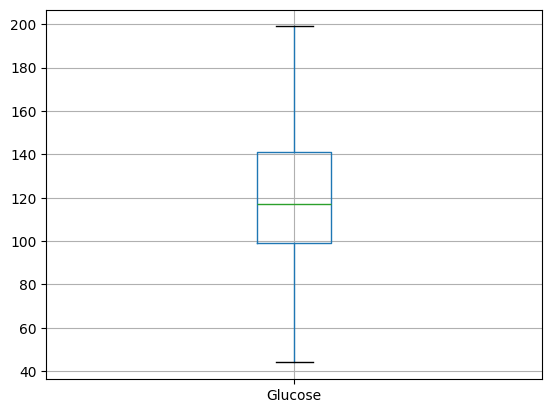

In [20]:
# Detect outliers using the IQR method and remove them
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply the function to remove outliers from a specific column (e.g., 'Glucose')
data_df = remove_outliers(data_df, 'Glucose')

# Visualize data after removing outliers (optional)
data_df.boxplot(column=['Glucose'])
plt.show()

### 2.3. Feature selection

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.128135       0.140481      -0.082435   
Glucose                      0.128135  1.000000       0.158429       0.075178   
BloodPressure                0.140481  0.158429       1.000000       0.207590   
SkinThickness               -0.082435  0.075178       0.207590       1.000000   
Insulin                     -0.074960  0.331550       0.088731       0.440858   
BMI                          0.014874  0.235666       0.280781       0.391542   
DiabetesPedigreeFunction    -0.036063  0.137246       0.040426       0.183840   
Age                          0.542558  0.267136       0.239038      -0.114804   
Outcome                      0.218877  0.494650       0.063602       0.072382   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.074960  0.014874                 -0.036063   
Glucose                   0.331550  0.235

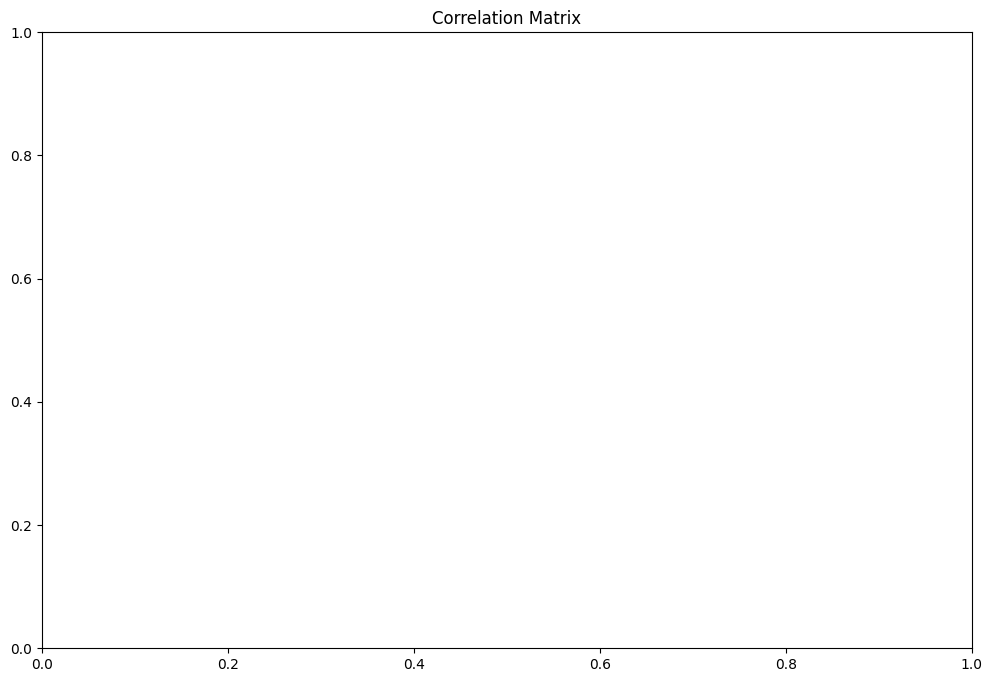

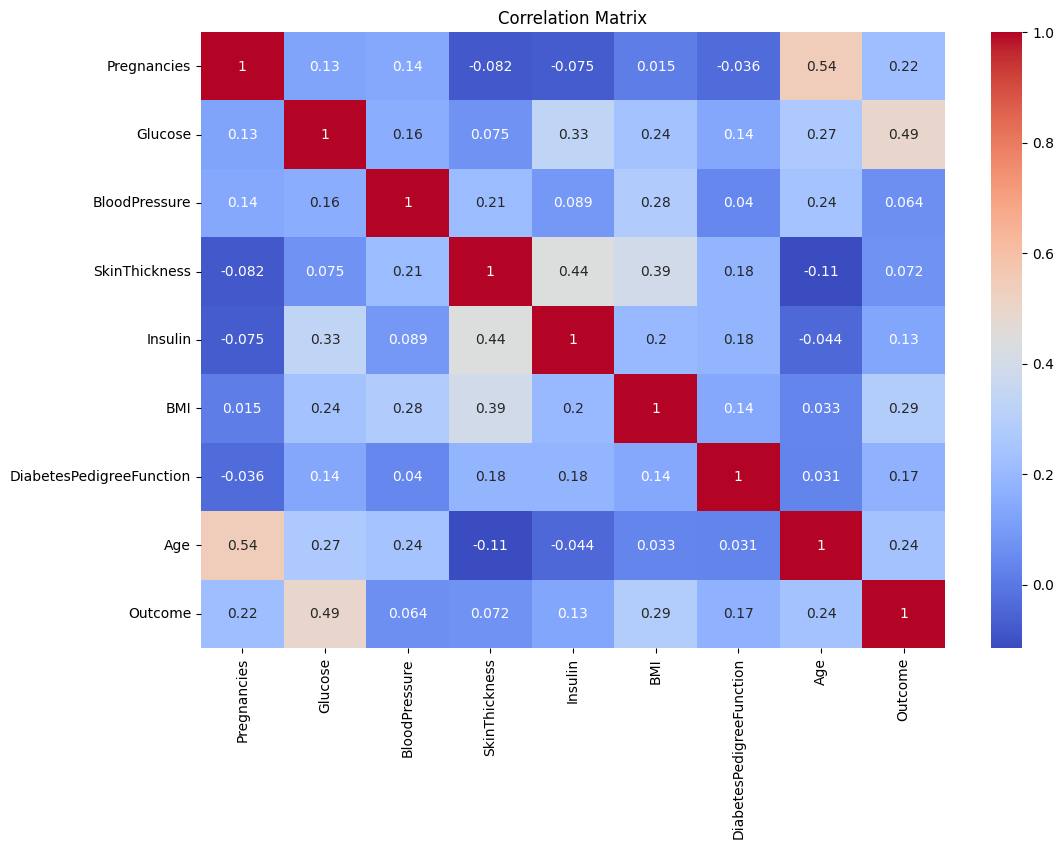

Pregnancies: 0.0683
Glucose: 0.3067
BloodPressure: 0.0885
SkinThickness: 0.0551
Insulin: 0.0605
BMI: 0.1700
DiabetesPedigreeFunction: 0.1453
Age: 0.1057


In [22]:
import seaborn as sns  
# Correlation analysis to remove highly correlated features
corr_matrix = data_df.corr()
print(corr_matrix)

# Visualizing correlations
plt.figure(figsize=(12, 8))
plt.title("Correlation Matrix")
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Remove highly correlated features (e.g., threshold of 0.9)
# Example: drop features with high correlation
# data_df = data_df.drop(columns=['feature_name'])

# Feature importance using a Decision Tree
model = DecisionTreeClassifier(random_state=315)
model.fit(training_features, training_labels)

# Show feature importance
importances = model.feature_importances_
features = training_features.columns
for feature, importance in zip(features, importances):
    print(f'{feature}: {importance:.4f}')

## 3. Model training

In [23]:
# Instantiate the Decision Tree model
model = DecisionTreeClassifier(random_state=315)

# Train the model
model.fit(training_features, training_labels)

# Evaluate model performance on the testing set
predictions = model.predict(testing_features)
accuracy = accuracy_score(testing_labels, predictions)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.75


## 4. Model optimization

### 4.1. Hyperparameter optimization

In [24]:
# from scipy.stats import uniform
# from sklearn.model_selection import RandomizedSearchCV

# Instantiate the model
model=DecisionTreeClassifier(random_state=315)

# Define the cross-validation strategy
cross_validation=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

# Define the hyperparameter search space
distributions={
    'max_depth': list(range(1, 50)),
    'min_samples_split': list(range(5, 50)),
    'min_samples_leaf': list(range(5, 50))
}

# Set-up the search
search=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cross_validation,
    n_iter=50,
    random_state=315,
    return_train_score=True
)

results=search.fit(training_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'min_samples_split': 9, 'min_samples_leaf': 28, 'max_depth': 40}


### 4.2. Cross-validation of optimized model

In [25]:
# Cross-validation on the optimized model
optimized_model = search.best_estimator_

# Perform cross-validation
cross_val(optimized_model, training_features, training_labels)

Cross-validation accuracy: 76.23 +/- 4.88%


array([0.73863636, 0.71590909, 0.73863636, 0.78409091, 0.78409091,
       0.71264368, 0.86206897])

### 4.3. Final model evaluation

In [26]:
# Evaluate the final optimized model on the test set
final_predictions = optimized_model.predict(testing_features)

# Evaluate accuracy
final_accuracy = accuracy_score(testing_labels, final_predictions)
print(f"Final model accuracy on the test set: {final_accuracy:.2f}")

Final model accuracy on the test set: 0.75
